In [1]:
from keras import applications
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.callbacks import CSVLogger
import tensorflow as tf
#from scipy.ndimage import imread
import numpy as np
import random
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D, LeakyReLU
from keras import backend as K
import keras
from keras.callbacks import CSVLogger, ModelCheckpoint
from keras.backend.tensorflow_backend import set_session
from keras import optimizers
import h5py
from sklearn.preprocessing import MinMaxScaler
import os
import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

In [3]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

In [4]:
with h5py.File(''.join(['data/bitcoin2015to2019_close.h5']), 'r') as hf:
    datas = hf['inputs'].value
    labels = hf['outputs'].value
    input_times = hf['input_times'].value
    output_times = hf['output_times'].value
    original_inputs = hf['original_inputs'].value
    original_outputs = hf['original_outputs'].value
    original_datas = hf['original_datas'].value

In [22]:
scaler=MinMaxScaler()
#split training validation
training_size = int(0.8* datas.shape[0])
training_datas = datas[:training_size,:,:]
training_labels = labels[:training_size,:,:]
validation_datas = datas[training_size:,:,:]
validation_labels = labels[training_size:,:,:]
validation_original_outputs = original_outputs[training_size:,:,:]
validation_original_inputs = original_inputs[training_size:,:,:]
validation_input_times = input_times[training_size:,:,:]
validation_output_times = output_times[training_size:,:,:]

In [23]:
ground_true = np.append(validation_original_inputs,validation_original_outputs, axis=1)
ground_true.shape

(15, 272, 1)

In [24]:
ground_true_times = np.append(validation_input_times,validation_output_times, axis=1)
ground_true_times.shape

(15, 272, 1)

In [25]:
step_size = datas.shape[1]
batch_size= 8
nb_features = datas.shape[2]
epochs = 1

In [9]:
model = Sequential()
model.add(Conv1D(activation='relu',
input_shape=(step_size, nb_features), strides=3,
filters=8, kernel_size=8))
model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Conv1D(activation='relu', strides=2,
filters=8, kernel_size=8))
model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Conv1D(strides=2, filters=nb_features,
kernel_size=8))

W1019 21:53:22.835716 19824 deprecation_wrapper.py:119] From C:\Anaconda3\envs\deep-learning\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1019 21:53:22.839704 19824 deprecation_wrapper.py:119] From C:\Anaconda3\envs\deep-learning\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1019 21:53:22.848681 19824 deprecation_wrapper.py:119] From C:\Anaconda3\envs\deep-learning\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1019 21:53:22.908520 19824 deprecation_wrapper.py:119] From C:\Anaconda3\envs\deep-learning\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1019 21:53:22.931

In [20]:
model.load_weights('weights_paper/bitcoin2015to2019_close_CNN_2_relu-80-0.00339.hdf5')
model.compile(loss='mse', optimizer='adam')

In [26]:
predicted = model.predict(validation_datas)
predicted_inverted = []

# In[7]:
for i in range(original_datas.shape[1]):
    scaler.fit(original_datas[:,i].reshape(-1,1))
    predicted_inverted.append(scaler.inverse_transform(predicted[:,:,i]))
print(np.array(predicted_inverted).shape)
#get only the close data
ground_true = ground_true[:,:,0].reshape(-1)
ground_true_times = ground_true_times.reshape(-1)
ground_true_times = pd.to_datetime(ground_true_times, unit='s')
# since we are appending in the first dimension
predicted_inverted = np.array(predicted_inverted)[0,:,:].reshape(-1)
print(np.array(predicted_inverted).shape)
validation_output_times = pd.to_datetime(validation_output_times.reshape(-1), unit='s')

(1, 15, 16)
(240,)


In [27]:
ground_true_df = pd.DataFrame()
ground_true_df['times'] = ground_true_times
ground_true_df['value'] = ground_true
ground_true_df.head()

,times,value
0,2018-09-26 10:00:00,6530.462000
1,2018-09-26 12:00:00,6484.705130
2,2018-09-26 14:00:00,6536.958386
3,2018-09-26 16:00:00,6535.557900
4,2018-09-26 18:00:00,6490.288578


In [28]:
ground_true_df = pd.DataFrame()
ground_true_df['times'] = ground_true_times
ground_true_df['value'] = ground_true
ground_true_df.set_index('times').reset_index()
ground_true_df.shape

(4080, 2)

In [29]:
prediction_df = pd.DataFrame()
prediction_df['times'] = validation_output_times
prediction_df['value'] = predicted_inverted
prediction_df.shape

(240, 2)

In [30]:
prediction_df.head()

,times,value
0,2018-10-17 18:00:00,6557.005859
1,2018-10-17 20:00:00,6584.394043
2,2018-10-17 22:00:00,6563.319824
3,2018-10-18 00:00:00,6542.517090
4,2018-10-18 02:00:00,6538.840332


In [31]:
prediction_df = prediction_df.loc[(prediction_df["times"].dt.year == 2019 )&(prediction_df["times"].dt.month > 7 ),: ]
ground_true_df = ground_true_df.loc[(ground_true_df["times"].dt.year == 2019 )&(ground_true_df["times"].dt.month > 7 ),:]

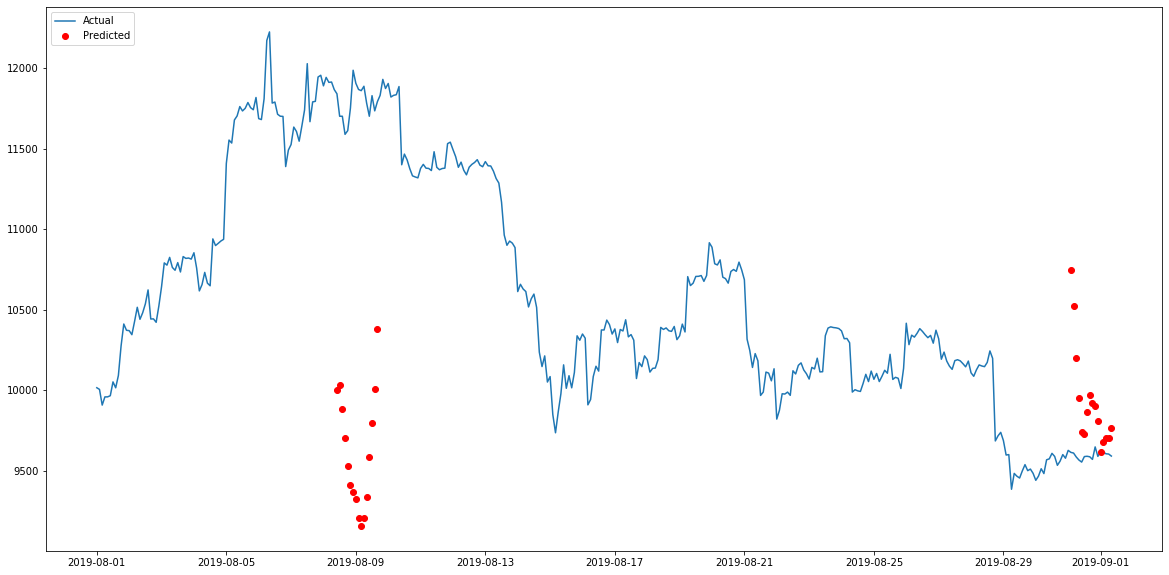

In [32]:
plt.figure(figsize=(20,10))
plt.plot(ground_true_df.times,ground_true_df.value, label = 'Actual')
plt.plot(prediction_df.times,prediction_df.value,'ro', label='Predicted')
plt.legend(loc='upper left')
plt.savefig('result_paper/bitcoin2015to2019_close_CNN_2_relu_result.png')
plt.show()

In [33]:
from sklearn.metrics import mean_squared_error
mean_squared_error(validation_original_outputs[:,:,0].reshape(-1),predicted_inverted)

1300457.7818458194